# Variational Autoencoders

In this laboratory we will implement a variational autoencoder (VAE) that learns to represent the MNIST dataset.

We start by loading the required modules

In [1]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from torch.utils.tensorboard import SummaryWriter

from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
torch.manual_seed(6161) # set seed to replicate results
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Hyperparameters

- `X_DIM`: $(N)$ input dimension
- `LATENT_DIM` $(D)$: dimension of latent variable $Z$
- `BATCH_SIZE`$(B)$: batch size
- `HIDDEN_DIM`: hidden simension
- `LEARNING_RATE`: we use a constant LR of $1e^{-4}$. Optionally, you can upgrade the training by using a scheduler.
- `NUM_EPOCHS`

In [2]:
# Hyper-parameters

X_DIM  = 784
LATENT_DIM = 64
BATCH_SIZE = 100
HIDDEN_DIM = 400
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100


## Load dataset

Function that loads the MNIST dataset and returns it as a pair of `torch.utils.Dataloader`objects. 

In [3]:
def load_datasets():
    mnist_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    dataset_path = './datasets'
    train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers = 1, pin_memory=True)
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                               shuffle=False, num_workers = 1, pin_memory=True)

    return train_loader, test_loader

def load_datasets_label(label=5):
    mnist_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    dataset_path = './datasets'
    train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
    for dataset in [train_dataset, test_dataset]:
        indices = dataset.targets == label
        dataset.data,dataset.targets = dataset.data[indices], dataset.targets[indices]
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers = 1, pin_memory=True)
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                               shuffle=False, num_workers = 1, pin_memory=True)
    return train_loader, test_loader


## `NNet`: Building block for the encoder and decoder

The `NNet` class (that inherits from `torch.nn.Module`) is the building block for the encoder and decoder of the VAE. It is composed of 2 linear layers followed by another pair of layers to obtain the median and variance of the distribution. Specifically:

\begin{eqnarray*}
f_1 &=& \mathrm{ReLU}(\mathrm{wn}(x\cdot M_1 + b_1))\\
f_2 &=& \mathrm{ReLU}(\mathrm{wn}(f_1\cdot M_2 + b_2))\\
\mu &=& f_2\cdot M_{\mu} + b_{\mu}\\
\log\sigma^2&=&f_2\cdot M_{\sigma} + b_{\sigma}
\end{eqnarray*}

Where $\mathrm{wn}$ is a weight normalization module (`torch.nn.utils.weight_norm`). Weight Norm (as opposed to Batch Norm) is usually used in VAEs, because Batch Norm introduces noise during training, which although tolerable for classification hurts our ability to precisely reconstruct the input. By using Weight Norm, any noise introduced in our VAE is counted towards the regularization loss.

**Note**: Due to numerical stability, the module returns **the logarithm of the variance $\log \sigma^2$ instead of $\sigma^2$**.


In [4]:
class NNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = torch.nn.utils.weight_norm(torch.nn.Linear(input_dim, hidden_dim))
        self.fc2 = torch.nn.utils.weight_norm(torch.nn.Linear(hidden_dim, hidden_dim))
        self.fc_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.fc_logvar = torch.nn.Linear(hidden_dim, output_dim)
        with torch.no_grad():
            self.fc_logvar.weight.normal_(0, 0.08) # init in [-0.08,0.08] range
        self.ReLU = torch.nn.ReLU()

    def forward(self, input):
        input = self.ReLU(self.fc1(input))
        input = self.ReLU(self.fc2(input))
        mu = self.fc_mean(input)
        logvar = self.fc_logvar(input)
        logvar = logvar.clamp(-2.0, 2.0) # clip logvar to avoid NAN
        return mu, logvar


## Auxiliary functions for the ELBO loss function

### `gaussian_log_prob`

Compute $\log p(x)$ when $p$ is a normal distribution with median $\mu$ and a diagonal covariance matrix with values $\sigma$

Input:
- x: the input vector
- mu: $\mu$
- logvar: $\lambda = \log \sigma^2$

Output:

- $\log p(x; N(\mu, \mathrm{diag}(\sigma^2)))= -\frac{1}{2}(\log(2\pi) + \lambda + \frac{(x - \mu)^2}{e^\lambda})$



In [5]:
def gaussian_log_prob(x, mu, logvar):
    # x,mu,logvar: [batch_size, x_dim]
    result = None

    ### WRITE YOUR CODE HERE ###
    # (~1 line of code)
    result = - 1/2 * (math.log(2*math.pi) + logvar + pow(x-mu, 2)/ torch.exp(logvar))
    ########################  

    return result # [batch_size, x_dim]


# Test the `gaussian_log_prob`

In [6]:
# The output should be the following:
# tensor([[-1.1739, -2.0900, -1.7287, -1.2511, -1.0612]])

gaussian_log_prob(torch.tensor([[ 0.7141, -1.5304,  1.2726,  0.8150, -0.5334]]), torch.zeros(1,5), torch.zeros(1,5))


tensor([[-1.1739, -2.0900, -1.7287, -1.2511, -1.0612]])

### `kld`

Compute KL divergence between $q(x|z)$ and $p(z)$ where:
- $q(x|z)$ is a normal distribution with mean $\mu$ and diagonal covariance with values $\sigma^2$
- $p(z)$ is a normal distribution with mean $0$ and identity covariance matrix $I$

Input:
- mu: $\mu$
- logvar: $\lambda=\log \sigma^2$

Output:
- $\mathrm{KL}(q(x|z),p(z)) = -\frac{1}{2}(1+\lambda-\mu^2 - e^\lambda)$

In [7]:
def kld(mu, logvar):
    # mu, logvar: [batch_size, latent_dim]
    result = None

    ### WRITE YOUR CODE HERE ###
    # (~1 line of code)
    result = - 1/2 * (1 + logvar - pow(mu, 2) - torch.exp(logvar))
    ########################

    return result # [batch_size, latent_dim]

# Test KL divergence

In [8]:
# The output should be the following:
# tensor([[0.0060, 0.6879, 0.2190, 0.1772, 0.7523]])

mu = torch.tensor([[-0.0292,  1.1696, -0.6528,  0.5809, -1.2085]])
logvar = torch.tensor([[ 0.1454, -0.1275,  0.1497, -0.1903,  0.2832]])
kld(mu, logvar)

tensor([[0.0060, 0.6879, 0.2190, 0.1772, 0.7523]])

## VAE module

The variational autoencoder module (inherits from `torch.nn.Module`). It is composed by two components:
- `self.encoder` (class `NNet`) receives input `x` and returns $(\mu_z, \log\sigma_z^2)$
- `self.decoder` (class `NNet`) receives input `z` and returns $(\mu_x, \log\sigma_x^2)$

### `__init__` function

Look at the arguments given in the signature.

### `forward` function

Receives a batch of images $x$ of size $(B \times N)$ and does the following:
1. Send $x$ to the encoder to obtain $(\mu_z, \log \sigma_z^2)$
2. Use reparametrization trick (see `reparametrize` below) to obtain $z$.
3. Send $z$ to the decoder to obtain $(\mu_x, \log \sigma_x^2)$
4. return $(\mu_z, \log \sigma_z^2, \mu_x, \log \sigma_x^2)$

### `reparametrize` function

Given $(\mu_z, \log \sigma_z^2)$, sample a vector $z$. It does the following:
1. Sample a vector $u$ (that has the same shape as $\sigma$) from a normal ditribution with mean 1 and variance 0.
2. Return $z = \mu_z + u\odot\sigma_z$ 

### `reconstruct_loss` function

Compute reconstruct loss of negative ELBO. It returns $-\log p(x|z)$, where $p$ is a normal distribution with mean $\mu_x$ and diagonal covariance matrix diag$(\sigma_x^2)$. See `gaussian_log_prob` function above. **Note the negative sign before the logarithm**. 

Input:

- x: tensor with input images. Size $(B \times N)$

- mu_x ($\mu_x$) tensor with the means of the distribution. Size $(B \times N)$

- logvar_x ($\log \sigma_x^2)$: a tensor with the logarithm of the variances of the distribution. Size $(B \times N)$

Output:

- loss: a tensor $l$ of size $(B)$, where

  $l_i = \sum_{j=1}^{N} -\log p(x_i|z)_j$


### `regularization_loss` function

Compute regularization loss of ELBO. It returns $\mathrm{KL}(q(z|x);p(z))$, where $q(z|x)$ is a normal distribution of mean $u_z$ and diagonal covariance matrix diag($\sigma^2$) and $p(z)$ is a normal distribution with mean 0 and covariance matrix $I$. See `kld` function above.

Often, the output of the KL is transformed by a ReLU activation function.

Input:

- mu_z ($\mu_z$): tensor with the means of the distribution. Size $(B \times D)$

- logvar_z ($\log \sigma_z^2)$: tensor with the logarithm of the variances of the distribution. Size $(B \times D)$

Output:

- a tensor $l$ of size $(B)$, where

  $l_i = \sum_{j=1}^{D} \mathrm{KL}(q(z|x_i); p(z))_j$

### `negative_elbo` function

Given $(x, \mu_z, \log \sigma_z^2, \mu_x, \log \sigma_x^2)$, compute negative ELBO $= -\log p(x|z) + \mathrm{KL}(q(z|x);p(z))$ using the `reconstruct_loss` and `regularization_loss` methods above.

Input:

- $x$ batch of images. Size $(B \times N)$
- $(\mu_z, \log \sigma_z^2)$ parameters of distribution $q(z|x)$. Size $(B \times D)$
- $(\mu_x, \log \sigma_x^2)$ parameters of distribution $p(x|z)$. Size $(B \times N)$

Output:

- a tuple (`rec_loss`, `regu_loss`) where:
   - `rec_loss`: reconstruction loss. Size $(B)$
   - `regu_loss`: regularization loss. Size $(B)$

### `predict` function

Generate new images using learned weights. The procedure to generate new images is:

1. sample $z$ from $\mathcal{N}(0, I)$. Look at the code in the `reparametrize` method to learn how to do it.
2. pass $z$ through the decoder to obtain $(\mu_x, \log \sigma_x^2)$
3. sample $\widehat{x} \sim \mathcal{N}(\mu_x, \mathrm{diag}(\sigma_x^2))$ (use `torch.normal`)
4. return $\widehat{x}$


In [ ]:
class VAE(torch.nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, freebits=0.05):
        super(VAE,self).__init__()
        self.latent_dim = z_dim
        self.encoder = NNet(x_dim, h_dim, z_dim)
        self.decoder = NNet(z_dim, h_dim, x_dim)
        self.freebits = freebits * math.log(2)

    def forward(self, x):
        # x [batch_size, x_dim]
        mu_z = None
        logvar_z = None
        mu_x = None
        logvar_x = None

        ### WRITE YOUR CODE HERE ###
        ## (~3 lines of code)
        mu_z , logvar_z = self.encoder(x)
        z = self.reparameterize(mu_z, logvar_z)
        mu_x , logvar_x = self.decoder(z)
        ########################

        return mu_z, logvar_z, mu_x, logvar_x

    def reparameterize(self, mu, logvar):
        stddev = torch.exp(0.5*logvar)
        return mu + torch.FloatTensor(self.latent_dim).normal_().to(DEVICE) * stddev

    def reconstruct_loss(self, x, mu_x, logvar_x):
        # x [batch_size, x_dim]
        # mu_x [batch_size, x_dim]
        # logvar_x [batch_size, x_dim]
        rec_loss = None

        ### WRITE YOUR CODE HERE ###
        # You will need the following method:
        # - torch.sum https://pytorch.org/docs/stable/generated/torch.sum.html
        #
        # (~1 line of code)
        rec_loss = torch.sum(- gaussian_log_prob(x, mu_x, logvar_x), dim=1)
        ########################

        return rec_loss # [batch_size]

    def regularization_loss(self, mu_z, logvar_z):
        # mu_z [batch_size, latent_dim]
        # logvar_z [batch_size, latent_dim]
        regu_loss = None

        ### WRITE YOUR CODE HERE ###
        #
        # You will need the following method:
        # - torch.sum https://pytorch.org/docs/stable/generated/torch.sum.html
        #
        # (~1 line of code)
        regu_loss = torch.sum( kld(mu_z, logvar_z), dim =1)
        ########################

        return regu_loss # [batch_size]

    def negative_elbo(self, x, mu_z, logvar_z, mu_x, logvar_x):
        # x, mu_x, logvar_x: [batch_size, x_dim]
        # mu_z, logvar_z: [batch_size, latent_dim]
        rec_loss = None
        regu_loss = None

        ### WRITE YOUR CODE HERE ###
        rec_loss = self.reconstruct_loss(x, mu_x, logvar_x)
        regu_loss = self.regularization_loss(mu_z, logvar_z)
        ########################

        return rec_loss, regu_loss

    def predict(self):
        xhat = None

        ### WRITE YOUR CODE HERE ###
        #
        # You will need the following method:
        # - torch.normal https://pytorch.org/docs/stable/generated/torch.normal.html
        #
        # (~3 lines of code)
        z = torch.FloatTensor(self.latent_dim).normal_().to(DEVICE)
        mu_x , logvar_x = self.decoder(z)
        xhat = torch.normal(mu_x, torch.exp(1/2 *logvar_x))
        ########################

        return xhat # [x_dim]


## Training function

This function will train the VAE using the data in `loader`.

**EXERCISE** complete the code in the function. Specifically, given a batch $x$, you should:

1. Calculate $(\mu_x, \log \sigma_x^2, \mu_z, \log \sigma_z^2)$ for the images in the batch.
2. Compute the negative ELBO function (see the signature of the `negative_elbo`method above)
3. Set the loss by averaging the reconstruction loss and the regularization loss as returned by the `negative_elbo` method. Use `torch.mean` function.

In [ ]:
def train(model, loader, writer):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, amsgrad=True)
    steps_per_epoch = len(loader)
    log_every = min(100, steps_per_epoch)
    for epoch in range(NUM_EPOCHS):
        model.train()
        losses = []
        for i, (x, _) in enumerate(loader):
            if x.size(0) != BATCH_SIZE:
              # discard last incomplete batch
              continue
            x = x.view(BATCH_SIZE, X_DIM)
            x = x.to(DEVICE)
            optimizer.zero_grad()
            loss = None

            ### WRITE YOUR CODE HERE ###
            #
            # You will need the following method:
            # - torch.mean https://pytorch.org/docs/stable/generated/torch.mean.html
            #
            # (~3 lines of code)
            mu_z, logvar_z, mu_x, logvar_x = model.forward(x)
            rec_loss, regu_loss = model.negative_elbo(x, mu_z, logvar_z, mu_x, logvar_x)
            loss = torch.mean(rec_loss + regu_loss)
            ########################

            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if (i+1) % log_every == 0:
                print (f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{steps_per_epoch}], Loss: {loss.item():.8f} Rec/Reg({torch.mean(rec_loss):.8f}/{torch.mean(regu_loss):.8f})')
            if writer is not None:
                writer.add_scalar('training loss', loss.item(), epoch * steps_per_epoch + i)
        print (f'Epoch [{epoch+1}/{NUM_EPOCHS}] finished. Average loss: {sum(losses)/(len(losses)*BATCH_SIZE):.8f}')
        losses = []

# Load dataset

The dataset comprises images of digit '5' from MNIST. Each training instance $x$ is just a vector of $768$ components with the intensity of the pixels. Because the image is small, we do not use CNNs to process them (but we could, and results would be better).

In [ ]:
# Load MNIST images with label '5'

train_loader, test_loader = load_datasets_label(5)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



# Train the model

We train the VAE for 100 epochs using the training dataset. You should obtain the following average losses:
- 1 epoch: $7.08$
- 10 epochs: $1.23$
- 50 epochs: $0.71$
- 100 epochs: $0.59$

In [ ]:
model = VAE(X_DIM, HIDDEN_DIM, LATENT_DIM)
model = model.to(DEVICE)
train(model, train_loader, None)

Epoch [1/100] finished. Average loss: 6.90368920
Epoch [2/100] finished. Average loss: 3.49599178
Epoch [3/100] finished. Average loss: 1.71400482
Epoch [4/100] finished. Average loss: 1.42201451
Epoch [5/100] finished. Average loss: 1.33979353
Epoch [6/100] finished. Average loss: 1.30735868
Epoch [7/100] finished. Average loss: 1.28816733
Epoch [8/100] finished. Average loss: 1.27054926
Epoch [9/100] finished. Average loss: 1.23130602
Epoch [10/100] finished. Average loss: 1.21497050
Epoch [11/100] finished. Average loss: 1.15360310
Epoch [12/100] finished. Average loss: 1.09033841
Epoch [13/100] finished. Average loss: 1.03627912
Epoch [14/100] finished. Average loss: 1.00910758
Epoch [15/100] finished. Average loss: 0.98240173
Epoch [16/100] finished. Average loss: 0.98262563
Epoch [17/100] finished. Average loss: 0.91916875
Epoch [18/100] finished. Average loss: 0.90423048
Epoch [19/100] finished. Average loss: 0.88416975
Epoch [20/100] finished. Average loss: 0.86693745
Epoch [21

In [ ]:
def show_image(x):
    x = x.view(28, 28)

    fig = plt.figure()
    plt.imshow(x.detach().cpu().numpy())

def show_grid(batch):
    plt.figure(figsize=(10,10)) # specifying the overall grid size
    for i,x in enumerate(batch):
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        plt.imshow(x.view(28, 28).detach().cpu().numpy())
    plt.show()


# Sample from the model to create new images

Once the VAE is trained, we can throw the encoder away and sample from the decoder to generate new images. Hopefully, they will mimic the training images.

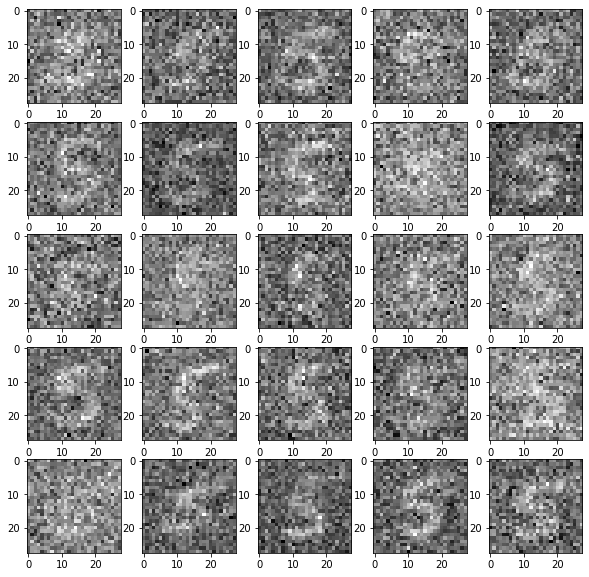

In [ ]:
X=[model.predict() for _ in range(25)]
show_grid(X)

# Try yourself

Load the whole dataset (using `load_datasets()` instead if `load_datasets_label(5)`) and re-train the model.